In [1]:

# Snippets copied liberally from https://blog.keras.io/building-autoencoders-in-keras.html

In [2]:
import tensorflow as tf
import numpy as np

from PIL import Image

from tqdm import tqdm


2024-01-11 10:42:03.453800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 10:42:03.453849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 10:42:03.455530: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 10:42:03.463909: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 10:42:04.322282: W tensorflow/compiler/tf2

In [107]:
def preprocess_image(img, resized_size):
    # convert PIL.Image to tensor
    img = img.resize((resized_size, resized_size))
    img = tf.keras.utils.img_to_array(img, data_format=None, dtype=None)
    img = img / 256
    return img

In [463]:
# emoji

import datasets

def get_preprocessed_emoji(resized_size):
    
    dataset = datasets.load_dataset("valhalla/emoji-dataset")
    
    x_train = np.array([preprocess_image(img, resized_size) for img in tqdm(dataset["train"][:2000]["image"])])
    x_test = np.array([preprocess_image(img, resized_size) for img in tqdm(dataset["train"][2000:]["image"])])

    return x_train, x_test

x_train, x_test = get_preprocessed_emoji(resized_size=64)

100%|█████████████████████████████████████████████████| 749/749 [00:00<00:00, 1905.71it/s]


In [464]:
from keras.datasets import mnist
def get_preprocessed_mnist(resized_size):
    (mnist_train, _), (mnist_test, _) = mnist.load_data()
    
    
    # nb: .convert('RGB') to force 3 channels, just so the shapes are the same.
    x_train = np.array([preprocess_image(Image.fromarray(img).convert('RGB'), resized_size) for img in tqdm(mnist_train[:30_000])])
    x_test = np.array([preprocess_image(Image.fromarray(img).convert('RGB'), resized_size) for img in tqdm(mnist_test)])

    return x_train, x_test

# x_train, x_test = get_preprocessed_mnist(resized_size=32)

In [465]:
# x_train = x_train[idxs*100]

In [466]:
x_train.shape

(2000, 64, 64, 3)

In [467]:
# okay, fine, make an autoencoder
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Identity, Conv2DTranspose, BatchNormalization, Flatten, Reshape, Dense

from keras.callbacks import EarlyStopping

In [707]:
# Note, 8x8x4 has pretty good reproduction. But downscale/upscale is also about as good, so it's not too impressive.


inferred_size = x_train.shape[1]

encoder = tf.keras.Sequential([
    Input(shape=(inferred_size, inferred_size, 3)),

    Conv2D(64,kernel_size=3,activation='relu',padding='same',strides=1),
    MaxPooling2D((2, 2), padding='same'),
    BatchNormalization(),
    Conv2D(32,kernel_size=3,activation='relu',padding='same',strides=1),
    MaxPooling2D((2, 2), padding='same'),
    BatchNormalization(),
    Conv2D(16,kernel_size=3,activation='relu',padding='same',strides=1), 
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(32),
    
    
])

# deconvolution -> decoding 
decoder = tf.keras.Sequential([
    Dense(8*8*16),
    Reshape((8, 8, 16)),
    # Conv2D(16,kernel_size=3,strides=1,activation='relu',padding='same'), #strides=2
    # BatchNormalization(),
    UpSampling2D((2, 2)),
    Conv2D(32,kernel_size=3,strides=1,activation='relu',padding='same'),
    BatchNormalization(),
    UpSampling2D((2, 2)),
    Conv2D(64,kernel_size=3,strides=1,activation='relu',padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3,kernel_size=(3,3),activation='sigmoid',padding='same')
])


autoencoder = tf.keras.Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [708]:
encoder.summary()

Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_317 (Conv2D)         (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_128 (MaxPool  (None, 32, 32, 64)        0         
 ing2D)                                                          
                                                                 
 batch_normalization_163 (B  (None, 32, 32, 64)        256       
 atchNormalization)                                              
                                                                 
 conv2d_318 (Conv2D)         (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_129 (MaxPool  (None, 16, 16, 32)        0         
 ing2D)                                                          
                                                    

In [709]:
history = autoencoder.fit(
    x_train, x_train, 
    epochs=100, batch_size=128, validation_data=(x_test, x_test), 
    # callbacks=[EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=10)]
)

Epoch 1/100
16/16 [==============================] - 3s 49ms/step - loss: 0.0940 - val_loss: 0.1201
Epoch 2/100
16/16 [==============================] - 1s 35ms/step - loss: 0.0582 - val_loss: 0.0986
Epoch 3/100
16/16 [==============================] - 1s 34ms/step - loss: 0.0469 - val_loss: 0.0826
Epoch 4/100
16/16 [==============================] - 1s 36ms/step - loss: 0.0408 - val_loss: 0.0760
Epoch 5/100
16/16 [==============================] - 1s 35ms/step - loss: 0.0375 - val_loss: 0.0697
Epoch 6/100
16/16 [==============================] - 1s 35ms/step - loss: 0.0356 - val_loss: 0.0681
Epoch 7/100
16/16 [==============================] - 1s 36ms/step - loss: 0.0338 - val_loss: 0.0696
Epoch 8/100
16/16 [==============================] - 1s 34ms/step - loss: 0.0324 - val_loss: 0.0693
Epoch 9/100
16/16 [==============================] - 1s 35ms/step - loss: 0.0311 - val_loss: 0.0707
Epoch 10/100
16/16 [==============================] - 1s 36ms/step - loss: 0.0301 - val_loss: 0.0691

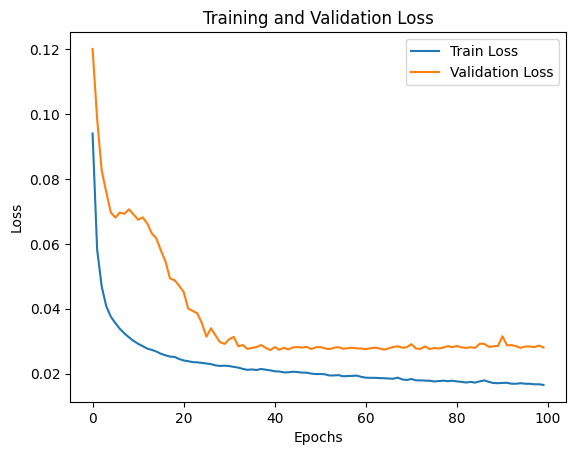

In [710]:
import matplotlib.pyplot as plt

# Obtain the training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [711]:
# okay, so what is the performance?  Let's evaluate reconstruction loss.

# might want to evaluate both against x_train and x_test, so just define x_eval

x_eval = x_train

In [712]:
mse = tf.keras.losses.MeanSquaredError()

recovered = autoencoder.predict(x_eval)

63/63 [==============================] - 0s 4ms/step


In [713]:
mse(recovered, x_eval).numpy()

0.016292926

In [714]:
# how does this compare against a simple baseline of: 1. downsample and 2. re-upsample

bottleneck_layer_size = np.prod(encoder.layers[-1].output_shape[1:])
equivalent_downsample = int((bottleneck_layer_size / 1) ** 0.5)  # use as many "numbers" (forget precision for now) as the bottleneck layer.

def baseline_recover(item):
    original_size = item.shape[0]
    img = tf.keras.utils.array_to_img(item, data_format=None, scale=True, dtype=None)
    img = img.resize((equivalent_downsample, equivalent_downsample))
    img = img.resize((original_size, original_size))
    img = tf.keras.utils.img_to_array(img, data_format=None, dtype=None)
    img /= 256
    return img
    

In [715]:
recovered_downsample = np.array([baseline_recover(img) for img in x_eval])

In [716]:
mse(recovered_downsample, x_eval).numpy()

0.03879966

In [717]:
# compare the actual images

In [718]:
def view_images(images):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 8))

    for i, img in enumerate(images):
        # img = Image.open(images[i])
        axes[i].imshow(img, cmap='gray', vmin=0, vmax=255)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


Originals:


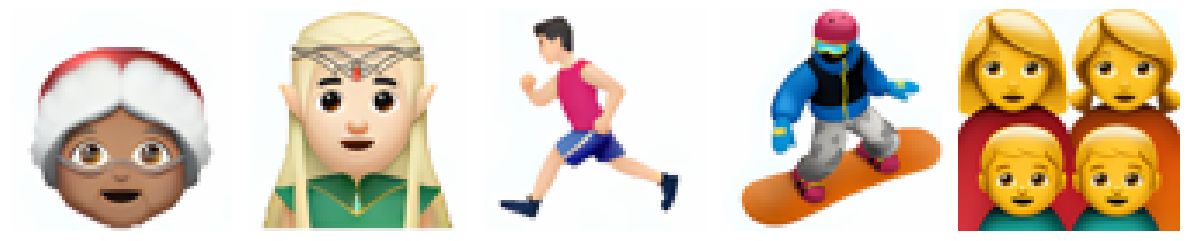

AE Recovered:


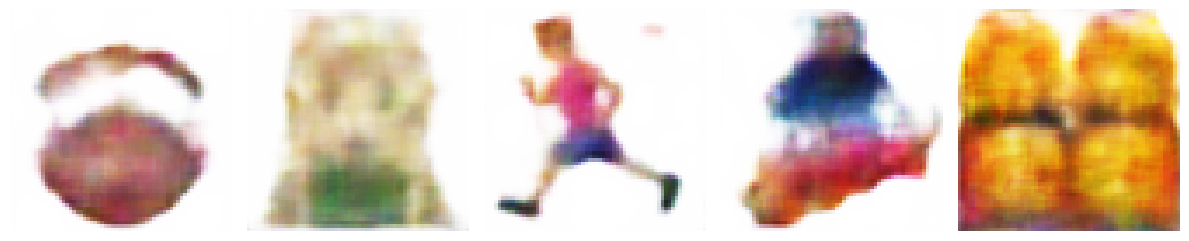

Downsample/Upsample baseline:


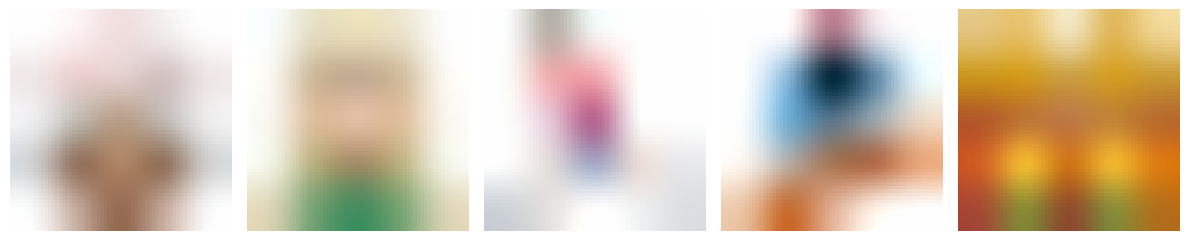

In [719]:
idxs = [12, 143, 222, 314, 612]
print("Originals:")
view_images(x_eval[idxs])

print("AE Recovered:")
view_images(recovered[idxs])

print("Downsample/Upsample baseline:")
view_images(recovered_downsample[idxs])

In [720]:
# compute mse for just these images
mse(recovered_downsample[idxs], x_eval[idxs]).numpy()

0.03541518

In [721]:
mse(recovered[idxs], x_eval[idxs]).numpy()

0.019091327

In [722]:
bottleneck_layer_size

32

# Okay, here's where we are: 
 - the same architecture works for both mnist and emoji
 - for emoji, it looks like the reconstruction loss is numerically better but the images look worse? (for 128x128; for 32
 - and everything as expected (obviously) for emojis. 

Other things I want to try:  
    - overfit more! Maybe a single image.
    - play with some of the same parameters as last time.
    - maybe I want to change the loss function? 
     - or maybe things look subjectively better if I add some smoothing or something?
    - try to decrease model complexity, and do I get the same issues as before? In particular, try again with fewer kernels?
     

Params I'm tuning: 
 - size: [32, 128, 256]
 - dataest: digits or emoji
 - architecture
 - bottleneck:
   - flatten?
   - have a dense layer?


# okay, so let's just play with size=32 for now.

### Open problems right now: 
1. autoencoder has a better recovery error but the images look subjectively worse.  Other loss functions?